Make a chart showing the running total of fatality crashes by year. 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib._color_data import BASE_COLORS, TABLEAU_COLORS, CSS4_COLORS, XKCD_COLORS
from datetime import datetime, timedelta
import pytz
import inflect
p = inflect.engine()

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

from crash_data_analysis import CrashDataAnalysis

In [2]:
%%time
cda = CrashDataAnalysis()
df = cda.crash_dataframe(
    verbose=True
#     , csv_file='data/denver_crashes_2022_11_05__10_01.csv'
)

Reading file: data/denver_crashes_2023_01_19__14_31.csv
Max timestamp: Wed Jan 18, 6:48 PM (0.83 days ago)
Deadly crashes this year: 3
CPU times: user 12.8 s, sys: 635 ms, total: 13.4 s
Wall time: 14 s


In [3]:
# Limit the date range
# df = df[df.reported_date.dt.year < 2023].copy()

# Aggregate fatality crashes by year and day of year

crashes_by_day_of_year = pd.pivot_table(
    data=df
    , values='fatality'
    # , values='sbi_or_fatality'
    # , values='one'
    , index='crash_day_of_year'
    , columns='crash_year'
    , aggfunc='sum'
    , fill_value=None
    )

running_total_crashes = crashes_by_day_of_year.cumsum()

this_year = df.reported_date.max().year
max_day_of_year = df.reported_date.max().day_of_year

In [4]:
# Determine the number of days in each year. 365 normally, 366 for leap years

days_in_year = pd.Series(index=sorted(df.crash_year.unique()), dtype=int)

for year in sorted(df.crash_year.unique()):
    
    if year == this_year:
        days_in_year.loc[year] = max_day_of_year

    else:
        days_in_year.loc[year] = pd.Timestamp(year, 12, 31).dayofyear

# Series showing the total number of days in each year, for trendline chart
total_days_in_year = days_in_year.copy()
total_days_in_year.loc[this_year] = pd.Timestamp(this_year, 12, 31).dayofyear

In [5]:
# Make DataFrame with info about every month

first_of_month = pd.DataFrame({'month_int': range(1,13)})
first_of_month['month_str'] = first_of_month.apply(
    lambda row: pd.Timestamp(this_year, row.month_int, 1).strftime('%b'), axis=1)
first_of_month['day_of_year'] = first_of_month.apply(
    lambda row: pd.Timestamp(this_year, row.month_int, 1).day_of_year, axis=1)

first_of_month['label'] = first_of_month['month_str'] + '\n1'
first_of_month.loc[12, 'month_int'] = 13
first_of_month.loc[12, 'label'] = 'EOY'
first_of_month.loc[12, 'day_of_year'] = 366

In [6]:
fatality_crashes_by_year = df.groupby('crash_year').fatality.sum()

In [7]:
fatality_crash_per_day = fatality_crashes_by_year / days_in_year

projected_fatality_crashes_by_year = fatality_crashes_by_year.astype(float).copy()
projected_fatality_crashes_by_year[this_year] = (
    fatality_crash_per_day[this_year] * pd.Timestamp(this_year, 12, 31).dayofyear
)

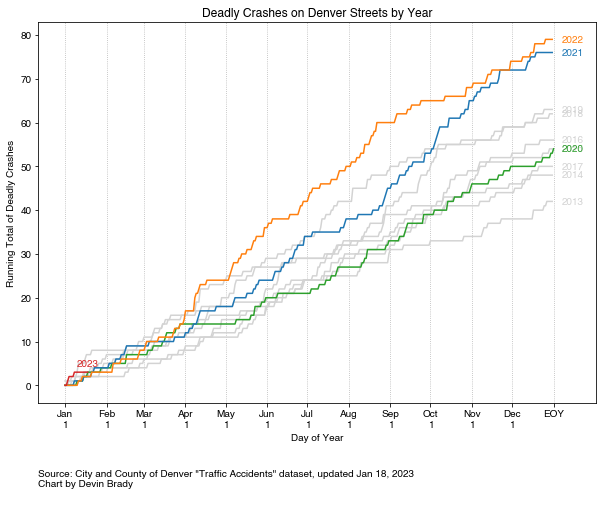

In [8]:
# Make the running total chart
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(figsize=(10,7))

max_x_value = 380
plt.plot(range(0, max_x_value), [1] * max_x_value, alpha=0)

year_colors = {
#     2019: 'tab:brown'
    2020: 'tab:green'
    , 2021: 'tab:blue'
    , 2022: 'tab:orange'
    , 2023: 'tab:red'
}

for year in sorted(df.crash_year.unique()):
    if year in year_colors.keys():
        color = year_colors[year]
    else:
        color = 'lightgray'
        
    plt.plot(running_total_crashes[year], label=year, color=color)
    
    # trendline
#     plt.plot(
#         [0, total_days_in_year[year]]
#         , [0, projected_fatality_crashes_by_year[year]]
#         , color=color
#         , linestyle=':'
#     )
    
    if year == this_year:
        annotation_x = max_day_of_year
        annotation_y = max(running_total_crashes[year]) + 2
    else:
        annotation_x = max_x_value
        annotation_y = max(running_total_crashes[year])

    ax.annotate(
        xy=(annotation_x, annotation_y)
        , text=year
        , color=color
        , fontweight='bold'
        , horizontalalignment='center'
        , verticalalignment='center'
    )

    
plt.xticks(ticks=first_of_month['day_of_year'], labels=first_of_month['label'])
plt.grid(axis='x', linestyle=':')

citation = f"""
Source: City and County of Denver "Traffic Accidents" dataset, updated {df.reported_date.max().strftime('%b %-d, %Y')}
Chart by Devin Brady
"""

ax.annotate(xy=(0, -0.2), text=citation, xycoords='axes fraction', ha='left', va='center')
plt.xlabel('Day of Year')
plt.ylabel('Running Total of Deadly Crashes')
plt.title('Deadly Crashes on Denver Streets by Year')
_ = plt.savefig(
    'images/deadly_crashes_running_total.png', transparent=False, facecolor='white', bbox_inches='tight')

## Counts

In [9]:
fatality_crashes_by_year

crash_year
2013    42
2014    48
2015    54
2016    56
2017    50
2018    62
2019    63
2020    54
2021    76
2022    79
2023     3
Name: fatality, dtype: int64

crash_year
2013    3.0
2014    7.0
2015    3.0
2016    2.0
2017    3.0
2018    2.0
2019    2.0
2020    3.0
2021    2.0
2022    2.0
2023    3.0
Name: 18, dtype: float64

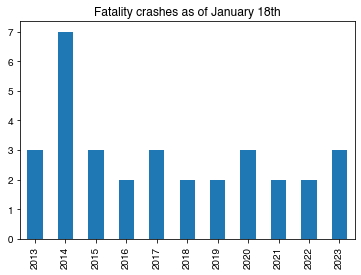

In [10]:
# Fatality crashes as of this day in the year
running_total_crashes.loc[max_day_of_year].plot(kind='bar')

date_string = df.reported_date.max().strftime('%B ')
date_string += p.ordinal(df.reported_date.max().strftime('%-d'))

plt.title(f"Fatality crashes as of {date_string}")

_ = plt.xlabel('')

running_total_crashes.loc[max_day_of_year]

In [11]:
days_per_fatality_crash = days_in_year / fatality_crashes_by_year
days_per_fatality_crash

2013    8.690476
2014    7.604167
2015    6.759259
2016    6.535714
2017    7.300000
2018    5.887097
2019    5.793651
2020    6.777778
2021    4.802632
2022    4.620253
2023    6.000000
dtype: float64

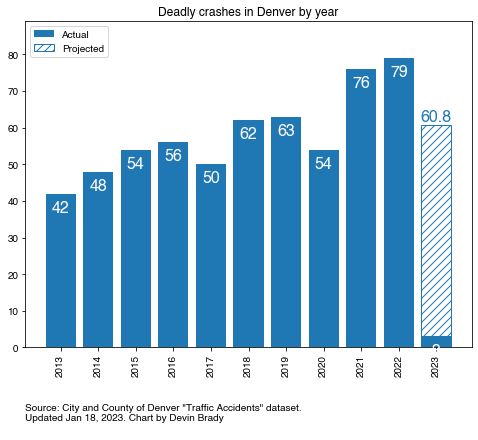

In [12]:
# Fatality crashes per year, current year projected
fig, ax = plt.subplots(figsize=(8,6))

ax.bar(
    x=this_year
    , height=projected_fatality_crashes_by_year[this_year]
    , hatch='///'
    , fill=False
    , edgecolor=TABLEAU_COLORS['tab:blue']
    , label='Projected'
)

ax.bar(
    x=fatality_crashes_by_year.index
    , height=fatality_crashes_by_year
    , color=TABLEAU_COLORS['tab:blue']
    , label='Actual'
)

ax.set_xticks(fatality_crashes_by_year.index, fontcolor='white')

for year in sorted(df.crash_year.unique()):
    plt.text(
        x=year
        , y=fatality_crashes_by_year[year] - 5
        , s=fatality_crashes_by_year[year]
        , ha='center'
        , color='white'
        , fontsize=16
        , fontweight='bold'
    )

    if year == this_year:
        plt.text(
            x=year
            , y=projected_fatality_crashes_by_year[year] + 1
            , s='{:.1f}'.format(projected_fatality_crashes_by_year[year])
            , ha='center'
            , color=TABLEAU_COLORS['tab:blue']
            , fontsize=16
            , fontweight='bold'
        )

plt.ylim([0, max(fatality_crashes_by_year.max(), projected_fatality_crashes_by_year[this_year]) + 10])
# ax.tick_params(axis='x' ,direction='in', pad=-50, rotation=90, colors='white', labelsize=16)
# ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', rotation=90) 
plt.title(f'Deadly crashes in Denver by year')

citation = f"""
Source: City and County of Denver "Traffic Accidents" dataset.
Updated {df.reported_date.max().strftime('%b %-d, %Y')}. Chart by Devin Brady
"""

ax.annotate(xy=(0, -0.2), text=citation, xycoords='axes fraction', ha='left', va='center')

handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper left')

_ = plt.savefig('images/deadly_crashes_barplot.png', transparent=False, facecolor='white', bbox_inches='tight')

## Deadly Crashes as a percentage of overall crashes

Is there deviation between these two metrics?

In [13]:
monthly_crash_rate = df.groupby(df.reported_date.dt.strftime('%Y-%m')).agg(
    crashes=('one', sum)
    , deadly_crashes=('fatality', sum)
)

monthly_crash_rate['crashes_per_deadly_crash'] = monthly_crash_rate['crashes'] / monthly_crash_rate['deadly_crashes']
monthly_crash_rate['deadly_crash_perc'] = monthly_crash_rate['deadly_crashes'] / monthly_crash_rate['crashes']

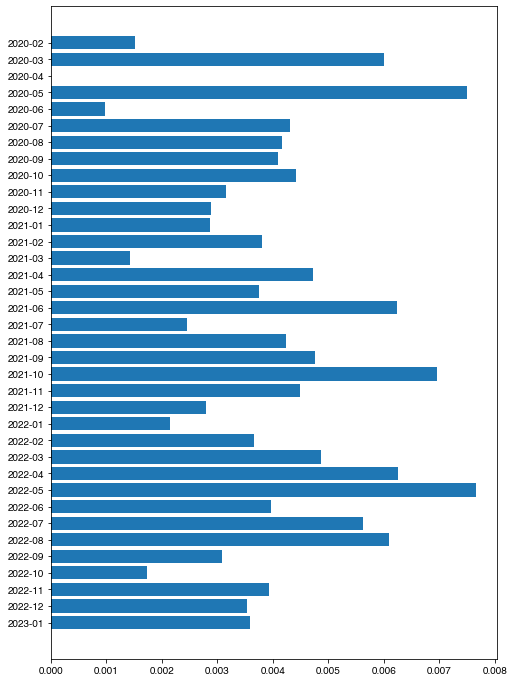

In [14]:
# monthly_crash_rate['crashes_per_deadly_crash'].tail(24).plot(type='bar')
fig, ax = plt.subplots(figsize=(8,12))

data_to_plot = monthly_crash_rate['deadly_crash_perc'].tail(36).iloc[::-1]

_ = ax.barh(
    y = data_to_plot.index
    , width = data_to_plot
)

## Year Thresholds

At what day in the current year are we matching the number of deadly crashes from previous years?

In [15]:
date_surpassed = pd.DataFrame(fatality_crashes_by_year)
date_surpassed.rename(columns={'fatality': 'deadly_crashes'}, inplace=True)
date_surpassed['date_surpassed_this_year'] = None

for year in date_surpassed.index:

    if date_surpassed.loc[this_year, 'deadly_crashes'] > date_surpassed.loc[year, 'deadly_crashes']:        
        day_of_year = int(
            running_total_crashes[
                running_total_crashes[this_year] > date_surpassed.loc[year, 'deadly_crashes']
            ].index.min()
        )
        date_this_year = (datetime(this_year, 1, 1) + timedelta(day_of_year - 1)).strftime('%B %-d, %Y')
        date_surpassed.loc[year, 'date_surpassed_this_year'] = date_this_year

date_surpassed.drop(index=this_year, inplace=True)
date_surpassed

,deadly_crashes,date_surpassed_this_year
crash_year,,
2013,42,None
2014,48,None
2015,54,None
2016,56,None
2017,50,None
2018,62,None
2019,63,None
2020,54,None
2021,76,None


## Recent deadly crashes

In [16]:
f = cda.recent_deadly_crashes(df)

                    incident_address              neighborhood_id       crash_time_str  days_between   days_ago
            N ALCOTT ST / W 38TH AVE                     Highland Wed Sep 14, 11:17 PM      8.826389 126.682992
   S QUEBEC ST / E CHERRY CREEK S DR             Virginia Village  Sat Sep 17, 1:02 PM      2.572917 124.110075
         E 46TH AVE / N FAIRPLAY WAY                    Montbello  Sat Sep 24, 1:19 PM      7.011806 117.098270
                  1700 BLOCK 19TH ST                Union Station Wed Oct 12, 11:53 PM     18.440278  98.657992
              2400 BLOCK N ROSLYN ST                 Central Park  Fri Oct 28, 1:04 AM     15.049306  83.608686
        N COLORADO BLVD / E MLK BLVD                      Skyland Fri Oct 28, 11:30 AM      0.434722  83.173964
          W 6TH AVE / N FEDERAL BLVD                       Barnum   Wed Nov 2, 1:11 PM      5.070139  78.103825
                  15TH ST / STOUT ST                          CBD  Sat Nov 12, 4:26 AM      9.677083  68

## One Crash

All of the info about one crash.

In [17]:
df[df.incident_id == 2022631618].squeeze()

incident_id                                         2022631618
top_traffic_accident_offense    TRAF - ACCIDENT - FATAL       
reported_date                        2022-12-09 20:31:00-07:00
incident_address                  N SHERIDAN BLVD / W 38TH AVE
geo_lon                                            -105.053243
geo_lat                                               39.76932
neighborhood_id                                            NaN
bicycle_ind                                                1.0
pedestrian_ind                                             0.0
SERIOUSLY_INJURED                                          NaN
FATALITIES                                                 NaN
sbi                                                      False
fatality                                                  True
sbi_or_fatality                                           True
crash_date                                          2022-12-09
crash_date_str                                  2022-12

## Pedestrian and Bicyclist crashes

In [18]:
df.groupby('crash_year')['bicycle_ind', 'pedestrian_ind'].sum()

,bicycle_ind,pedestrian_ind
crash_year,,
2013,323.0,555.0
2014,337.0,530.0
2015,346.0,562.0
2016,315.0,530.0
2017,324.0,538.0
2018,318.0,546.0
2019,283.0,520.0
2020,196.0,323.0
2021,162.0,456.0


In [19]:
df.groupby(df.reported_date.dt.strftime('%Y-%m'))['bicycle_ind', 'pedestrian_ind'].sum().tail(20)

,bicycle_ind,pedestrian_ind
reported_date,,
2021-06,22.0,41.0
2021-07,16.0,31.0
2021-08,16.0,39.0
2021-09,25.0,53.0
2021-10,14.0,69.0
2021-11,16.0,58.0
2021-12,8.0,38.0
2022-01,6.0,25.0
2022-02,5.0,27.0


Alt text

Line chart showing the running total for deadly crashes on Denver streets by year. The orange line shows 2022, it is far above other years, and curving upwards in the last few days. 

Bar plot showing the total number of deadly crashes by year in Denver. 2022 is projected to have 93.2 deadly crashes as of yesterday. 

## Save smaller file to CSV for Google My Maps

Maximum number of points is 2,000

Map: https://www.google.com/maps/d/edit?mid=1Cn1TekkCt5BUYC-X3EMAvmmqPY0Aj30&ll=39.75925871700066%2C-104.88997345&z=11

In [20]:
my_maps_columns = [
    'incident_id'
    , 'top_traffic_accident_offense'
    , 'reported_date'
    , 'incident_address'
    , 'geo_lon'
    , 'geo_lat'
]

# df.loc[df.fatality & df.geo_lon.notnull() & df.geo_lat.notnull(), my_maps_columns].to_csv(
#     'data/deadly_crashes_to_google_my_maps.csv', index=False)

In [21]:
df[['fatality', 'sbi_or_fatality']].sum()

fatality            587
sbi_or_fatality    3938
dtype: int64

In [22]:
print(citation)


Source: City and County of Denver "Traffic Accidents" dataset.
Updated Jan 18, 2023. Chart by Devin Brady



## Number each deadly crash

In [23]:
# df.sort_values(['id', 'msg_ts'], ascending=True).groupby(['id', 'topic']).cumcount() + 1
df['crash_num'] = df[df.fatality].groupby(['crash_year']).cumcount() + 1

In [24]:
df[(df.reported_date.dt.year == 2023) & (df.fatality)][['incident_address', 'crash_time_str', 'crash_num']]

,incident_address,crash_time_str,crash_num
18693,I25 HWYNB / E UNION AVE,"Tue Jan 3, 1:28 AM",1.0
24130,N COLORADO BLVD / E 23RD AVE,"Wed Jan 4, 8:35 PM",2.0
23649,300 BLOCK N FEDERAL BLVD,"Sun Jan 8, 1:13 AM",3.0


## Fatalities field

Is the field showing the count of fatalities in a crash accurate? Is it being filled in? 

In [25]:
df.groupby(df.reported_date.dt.year).FATALITIES.sum()

reported_date
2013    46.0
2014    47.0
2015    54.0
2016    60.0
2017    48.0
2018    62.0
2019    63.0
2020    56.0
2021    70.0
2022    50.0
2023     0.0
Name: FATALITIES, dtype: float64

In [26]:
# df[df.FATALITIES > 0].tail(20)